# Preliminary analysis comparing the different `surgeexposure.csv` options

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import re, os
import matplotlib.pyplot as plt
%matplotlib inline

Colorblind-friendly palette

In [2]:
plt.style.use('tableau-colorblind10')

Set `projdir` on your system, then everything else is defined relative to that. `pwd` will just give the directory that this Jupyter notebook is housed in.

In [3]:
projdir = os.getcwd()
datdir = projdir + "/../ciam-code/output/MonteCarlo"
plotdir = projdir + "/../ciam-code/figures"

If the plot directory `plotdir` doesn't exist, make it.

In [4]:
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
print("Will save plots to ",plotdir)

Will save plots to  /Users/aewsma/codes/CIAM_uncertainty_propagation/work_uncertainty_propagation/../ciam-code/figures


In [5]:
surge_options = [0,1,2]
scenarios = [(5,85)]

### Initialize some dicts of DataFrames 

Different dict eleemnts correspond to different SSP/RCP scenarios

In [6]:
dfS = [{scen : None for scen in scenarios} for surge in surge_options]
dfC = [{scen : None for scen in scenarios} for surge in surge_options]
dfSC = [{scen : None for scen in scenarios} for surge in surge_options]

## Read Monte Carlo simulation results

In [7]:
def subtract_ref_npv(dfO,dfG):
    nens = dfO.ens.max()
    npv_ref = np.zeros(nens)
    df1 = dfO.loc[dfO.time==1]
    for i in range(1,nens+1):
        # first 10 of the first timestep for a single ensemble member are OptimalCost
        # *10 to account for 10-year timestep vs annual costs
        npv_ref[i-1] = np.sum(np.array(df1.loc[df1.ens==i,"cost"])[:10])*10
    dfG.npv = dfG.npv - npv_ref
    return dfG

### SLR uncertainty only

In [8]:
for surge in surge_options:
    for (ssp,rcp) in scenarios:
        slrdir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge)+"_varySLR/CIAM MC1000/PostProcessing"
        dfS[surge][(ssp,rcp)] = pd.read_csv(slrdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge)+"_varySLR.csv")
        dfO = pd.read_csv(slrdir+"/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge)+"_varySLR.csv")
        dfS[surge][(ssp,rcp)] = subtract_ref_npv(dfO,dfS[surge][(ssp,rcp)])


### CIAM socioeconomic parameter uncertainty only

In [9]:
for surge in surge_options:
    for (ssp,rcp) in scenarios:
        ciamdir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge)+"_varyCIAM/CIAM MC1000/PostProcessing"
        dfC[surge][(ssp,rcp)] = pd.read_csv(ciamdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge)+"_varyCIAM.csv")
        dfO = pd.read_csv(ciamdir+"/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge)+"_varyCIAM.csv")
        dfC[surge][(ssp,rcp)] = subtract_ref_npv(dfO,dfC[surge][(ssp,rcp)])
        

### Both SLR and CIAM uncertainty

In [10]:
for surge in surge_options:
    for (ssp,rcp) in scenarios:
        bothdir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge)+"_varySLR_varyCIAM/CIAM MC1000/PostProcessing"
        dfSC[surge][(ssp,rcp)] = pd.read_csv(bothdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge)+"_varySLR_varyCIAM.csv")
        dfO = pd.read_csv(bothdir+"/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge)+"_varySLR_varyCIAM.csv")
        dfSC[surge][(ssp,rcp)] = subtract_ref_npv(dfO,dfSC[surge][(ssp,rcp)])


### _checking differences between surge options_

In [11]:
for scen in scenarios:
    print("===========================")
    print(scen)
    for surge in surge_options:
        print(surge,":",list(np.round(dfSC[surge][scen]["npv"][:500].quantile([.05,.25,.5,.75,.95]),0)))

(5, 85)
0 : [2414.0, 3336.0, 4161.0, 5025.0, 7018.0]
1 : [2229.0, 3365.0, 4291.0, 5261.0, 6825.0]
2 : [2248.0, 3249.0, 4128.0, 5062.0, 6627.0]


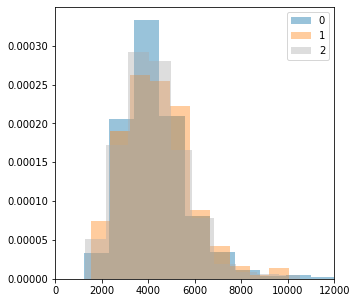

In [12]:
if len(scenarios)>1:
    fig,ax = plt.subplots(nrows=len(scenarios), ncols=1, figsize=(5,8))
    for a in range(len(scenarios)):
        for s in surge_options:
            ax[a].hist(dfSC[s][scenarios[a]].npv[:500], density=True, alpha=0.4, label=str(s))
            ax[a].set_xlim([0,12000])
        if a==0:
            ax[a].legend();
else:
    fig,ax = plt.subplots(nrows=len(scenarios), ncols=1, figsize=(5,5))
    for s in surge_options:
        ax.hist(dfSC[s][scenarios[0]].npv[:500], density=True, alpha=0.4, label=str(s))
        ax.set_xlim([0,12000])
        ax.legend();


### KDEs

In [13]:
kde = [{scen : None for scen in scenarios} for surge in surge_options]
kde_S = [{scen : None for scen in scenarios} for surge in surge_options]
kde_C = [{scen : None for scen in scenarios} for surge in surge_options]
for surge in surge_options:
    for scen in scenarios:
        kde[surge][scen] = stats.gaussian_kde(dfSC[surge][scen].npv[:500])
        kde_S[surge][scen] = stats.gaussian_kde(dfS[surge][scen].npv)
        kde_C[surge][scen] = stats.gaussian_kde(dfC[surge][scen].npv)

x = np.linspace(0,12000,500)
kde_plot = [{scen : None for scen in scenarios} for surge in surge_options]
kde_S_plot = [{scen : None for scen in scenarios} for surge in surge_options]
kde_C_plot = [{scen : None for scen in scenarios} for surge in surge_options]
for surge in surge_options:
    for scen in scenarios:
        kde_plot[surge][scen] = kde[surge][scen](x)
        kde_S_plot[surge][scen] = kde_S[surge][scen](x)
        kde_C_plot[surge][scen] = kde_C[surge][scen](x)

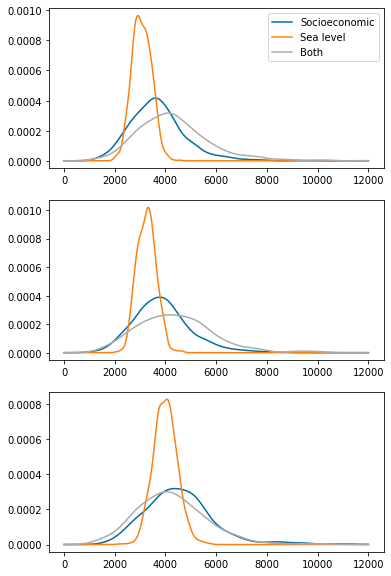

In [14]:
fig, ax = plt.subplots(len(surge_options),1,figsize=(6,10))
for surge in surge_options:
    ax[surge].plot(x,kde_C_plot[surge][(5,85)],label="Socioeconomic")
    ax[surge].plot(x,kde_S_plot[surge][(5,85)],label="Sea level")
    ax[surge].plot(x,kde_plot[surge][(5,85)],label="Both")
    if surge==0:
        ax[surge].legend()

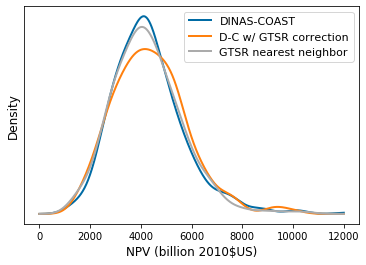

In [15]:
surge_labels = ["DINAS-COAST","D-C w/ GTSR correction","GTSR nearest neighbor"]
if len(scenarios)>1:
    fig, ax = plt.subplots(len(scenarios),1,figsize=(5,8))
    for s in range(len(scenarios)):
        for surge in surge_options:
            ax[s].plot(x,kde_plot[surge][scenarios[s]],label=str(surge))
        if s==0:
            ax[s].legend()
else:
    fig, ax = plt.subplots(len(scenarios),1,figsize=(6,4))
    for surge in surge_options:
        ax.plot(x,kde_plot[surge][scenarios[0]],label=surge_labels[surge],linewidth=2)
        ax.legend(fontsize=11)
    ax.set_xlabel("NPV (billion 2010$US)", fontsize=12);
    ax.set_ylabel("Density", fontsize=12); ax.set_yticks([])
    fig.savefig(plotdir+"/surgeexposure_check.pdf", bbox_inches='tight');